# Notebook 07 — Memory Ablation: Is Trajectory Memory the Missing Ingredient?

## Hypothesis

> The apparent failure of model-free HSP is **not** due to the optionality concept itself,
> but due to **absence of temporal memory** in the sampler.

### Sub-hypotheses

| ID | Statement | Test |
|----|-----------|------|
| **H1** | Pure nonlinearity (MLP without memory) will **not** materially change Tests 1–4 | Exp 2A |
| **H2** | Explicit short-term memory (windowed MLP) **may** reveal structural contraction | Exp 2B |
| **H3** | If neither changes results, trajectory is **not** the missing ingredient | Both |

### Experimental Design

| Sampler | Input | Learns dynamics? | Has memory? |
|---------|-------|-------------------|-------------|
| **Model-Free** (baseline) | x_t | No | No |
| **MLP memoryless** (Exp 2A) | x_t | Yes (nonlinear) | No |
| **Windowed MLP** (Exp 2B) | [x_{t-k}, …, x_t] | Yes (nonlinear) | Yes (k steps) |

All three samplers are evaluated with **identical** HSP metrics and evaluation protocol.
**No hyperparameter optimization.** This is a falsification experiment, not performance tuning.

> *"Before building a powerful model, we must determine whether the signal exists at all."*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
import time

warnings.filterwarnings("ignore")

plt.rcParams.update(
    {
        "figure.figsize": (14, 5),
        "figure.dpi": 120,
        "axes.grid": True,
        "grid.alpha": 0.3,
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
    }
)

# ── Constants ──────────────────────────────────────────────
SEED = 42
np.random.seed(SEED)

N_SEEDS = 30  # trajectories per system
N_FUTURES = 30  # sampled futures per time step
HORIZON = 15  # future horizon
WINDOW_K = 10  # memory window for windowed MLP
MLP_HIDDEN = 32  # hidden units
MLP_EPOCHS = 300  # training epochs (fixed — no tuning)
MLP_LR = 0.005  # learning rate (fixed — no tuning)
ROLLING_W = 20  # rolling window for observables

print(f"Constants: {N_SEEDS} seeds, {N_FUTURES} futures, H={HORIZON}, k={WINDOW_K}")
print("Setup complete")

Constants: 30 seeds, 30 futures, H=15, k=10
Setup complete


## System Generators & HSP Core Functions

Identical to Notebook 05 — same simulators, same thresholds, same observable detectors.

In [2]:
# ============================================================
# System Generators (identical to NB 04/05)
# ============================================================


def linear_degradation(x0=100.0, decay_rate=0.5, noise_std=2.0, T=200, seed=42):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = x[t - 1] - decay_rate + rng.normal(0, noise_std)
    return x


def regime_change_system(
    T=300,
    change_point=200,
    stable_mean=50.0,
    stable_noise=2.0,
    decline_rate=0.5,
    decline_noise=5.0,
    seed=42,
):
    rng = np.random.RandomState(seed)
    x = np.zeros(T)
    for t in range(T):
        if t < change_point:
            x[t] = stable_mean + rng.normal(0, stable_noise)
        else:
            x[t] = (
                stable_mean
                - decline_rate * (t - change_point)
                + rng.normal(0, decline_noise)
            )
    return x, change_point


def simulated_engine(T=200, n_sensors=5, failure_health=0.2, seed=42):
    rng = np.random.RandomState(seed)
    health = np.zeros(T)
    for t in range(T):
        health[t] = 1.0 / (1.0 + np.exp(0.05 * (t - T * 0.7)))
    collapse_time = np.argmax(health < failure_health)
    if collapse_time == 0 and health[0] >= failure_health:
        collapse_time = T
    return health, collapse_time


# ============================================================
# Trajectory Generator (unified interface)
# ============================================================

SYSTEMS = {
    "linear": {
        "gen": lambda seed: linear_degradation(
            x0=100.0, decay_rate=0.5, noise_std=2.0, T=200, seed=seed
        ),
        "threshold": 10.0,
        "noise_gen": lambda seed: linear_degradation(
            x0=100.0, decay_rate=0.5, noise_std=4.0, T=200, seed=seed
        ),
    },
    "engine": {
        "gen": lambda seed: simulated_engine(T=200, failure_health=0.2, seed=seed),
        "threshold": 0.2,
        "noise_gen": None,  # handled separately
    },
    "regime": {
        "gen": lambda seed: regime_change_system(
            T=300,
            change_point=200,
            stable_mean=50.0,
            stable_noise=2.0,
            decline_rate=0.5,
            decline_noise=5.0,
            seed=seed,
        ),
        "threshold": 20.0,
        "noise_gen": lambda seed: regime_change_system(
            T=300,
            change_point=200,
            stable_mean=50.0,
            stable_noise=4.0,
            decline_rate=0.5,
            decline_noise=10.0,
            seed=seed,
        ),
    },
}


def get_trajectory(sys_name, seed, noisy=False):
    """Generate trajectory + collapse time for a given system."""
    cfg = SYSTEMS[sys_name]
    gen = cfg["noise_gen"] if (noisy and cfg["noise_gen"]) else cfg["gen"]
    thresh = cfg["threshold"]

    result = gen(seed)

    if sys_name == "engine":
        health, ct = result
        if noisy:
            rng = np.random.RandomState(seed + 9999)
            health = health + rng.normal(0, 0.05, len(health))
        return health, ct, thresh
    elif sys_name == "regime":
        traj, cp = result
        ct = cp
        for t in range(cp, len(traj)):
            if traj[t] < thresh:
                ct = t
                break
        else:
            ct = len(traj)
        return traj, ct, thresh
    else:
        traj = result
        ct = 0
        for t in range(len(traj)):
            if traj[t] < thresh:
                ct = t
                break
        if ct == 0 and traj[0] >= thresh:
            ct = len(traj)
        return traj, ct, thresh


# ============================================================
# HSP Core (unchanged from NB 05)
# ============================================================


def compute_optionality(futures, threshold=10.0):
    """Fraction of futures that stay above threshold at all times."""
    viable = np.all(futures > threshold, axis=1)
    return viable.mean()


def measure_lead_time(signal, collapse_time, threshold=0.5, direction="below"):
    if direction == "below":
        alert_indices = np.where(signal < threshold)[0]
    else:
        alert_indices = np.where(signal > threshold)[0]
    if len(alert_indices) == 0:
        return 0
    first_alert = alert_indices[0]
    return max(0, collapse_time - first_alert)


# ============================================================
# Observable Detectors (unchanged)
# ============================================================


def moving_average(x, window=20):
    out = np.full_like(x, np.nan, dtype=float)
    for t in range(window, len(x)):
        out[t] = np.mean(x[t - window : t])
    return out


def rolling_slope(x, window=20):
    out = np.full_like(x, np.nan, dtype=float)
    t_arr = np.arange(window)
    for t in range(window, len(x)):
        w = x[t - window : t]
        slope, _, _, _, _ = stats.linregress(t_arr, w)
        out[t] = slope
    return out


def rolling_variance(x, window=20):
    out = np.full_like(x, np.nan, dtype=float)
    for t in range(window, len(x)):
        out[t] = np.var(x[t - window : t])
    return out


print("Systems and HSP core defined")
print(f"Systems: {list(SYSTEMS.keys())}")

Systems and HSP core defined
Systems: ['linear', 'engine', 'regime']


## Sampler Implementations

Three samplers, isolating **nonlinearity** vs **memory**:

1. **Model-Free**: Random walk from x_t. No learning, no memory. *(NB 05 baseline)*
2. **MLP Memoryless**: x_t → MLP → x̂_{t+1}. Learns nonlinear dynamics. No memory.
3. **Windowed MLP**: [x_{t-k}, …, x_t] → MLP → x̂_{t+1}. Learns dynamics **with** k-step memory.

All MLPs are trained **self-supervised** (predict next step) on each trajectory independently.
Noise is calibrated from prediction residuals. No tuning.

In [3]:
# ============================================================
# SimpleMLP — Numpy-only, one hidden layer, ReLU
# ============================================================


class SimpleMLP:
    """Minimal feedforward network. No dependencies beyond numpy."""

    def __init__(self, input_dim, hidden_dim=32, lr=0.005, seed=42):
        rng = np.random.RandomState(seed)
        # Xavier initialization
        self.W1 = rng.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = rng.randn(hidden_dim, 1) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(1)
        self.lr = lr

    def forward(self, X):
        """X: (n, input_dim) → predictions: (n,)"""
        self.z1 = X @ self.W1 + self.b1
        self.a1 = np.maximum(self.z1, 0)  # ReLU
        return (self.a1 @ self.W2 + self.b2).squeeze(-1)

    def fit(self, X, y, epochs=300):
        """Train with MSE + gradient descent. Returns final loss."""
        n = len(y)
        for _ in range(epochs):
            # Forward
            pred = self.forward(X)

            # Backward (all gradients before any update)
            d = ((pred - y) * 2.0 / n).reshape(-1, 1)
            dW2 = self.a1.T @ d
            db2 = d.sum(axis=0)
            d_z1 = (d @ self.W2.T) * (self.z1 > 0)
            dW1 = X.T @ d_z1
            db1 = d_z1.sum(axis=0)

            # Update
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

        return np.mean((self.forward(X) - y) ** 2)

    def predict(self, X):
        """Inference only (no gradient storage needed for this use)."""
        z1 = X @ self.W1 + self.b1
        a1 = np.maximum(z1, 0)
        return (a1 @ self.W2 + self.b2).squeeze(-1)


# ============================================================
# Sampler 1: Model-Free (baseline from NB 05)
# ============================================================


def make_model_free_sampler(trajectory, threshold):
    """Random walk from x_t. Drift & noise estimated from trajectory.

    No nonlinearity, no memory. Futures depend ONLY on current value x_t.
    """
    diffs = np.diff(trajectory)
    drift = np.mean(diffs)
    noise_std = np.std(diffs) + 0.01

    def sampler(t, N=30, H=15):
        rng = np.random.RandomState(t * 1000)
        futures = np.zeros((N, H))
        x = np.full(N, trajectory[t])
        for h in range(H):
            x = x + drift + rng.normal(0, noise_std, N)
            futures[:, h] = x
        return futures

    return sampler


# ============================================================
# Sampler 2: MLP Memoryless (Exp 2A)
# ============================================================


def make_mlp_sampler(
    trajectory, threshold, hidden=MLP_HIDDEN, lr=MLP_LR, epochs=MLP_EPOCHS, seed=42
):
    """x_t → MLP → x̂_{t+1}. Nonlinear dynamics, NO memory.

    Self-supervised: trained to predict next step from current step.
    Noise calibrated from residuals.
    """
    X = trajectory[:-1].reshape(-1, 1)
    y = trajectory[1:]

    # Standardize
    x_mean, x_std = X.mean(), X.std() + 1e-8
    X_norm = (X - x_mean) / x_std
    y_norm = (y - x_mean) / x_std

    mlp = SimpleMLP(1, hidden, lr, seed)
    mlp.fit(X_norm, y_norm, epochs)

    # Calibrate noise from residuals
    pred = mlp.predict(X_norm)
    noise_std = np.std(y_norm - pred) + 0.01

    def sampler(t, N=30, H=15):
        rng = np.random.RandomState(t * 1000)
        futures = np.zeros((N, H))
        x = np.full(N, (trajectory[t] - x_mean) / x_std)
        for h in range(H):
            pred = mlp.predict(x.reshape(-1, 1))
            x = pred + rng.normal(0, noise_std, N)
            futures[:, h] = x * x_std + x_mean
        return futures

    return sampler


# ============================================================
# Sampler 3: Windowed MLP (Exp 2B)
# ============================================================


def make_windowed_sampler(
    trajectory,
    threshold,
    k=WINDOW_K,
    hidden=MLP_HIDDEN,
    lr=MLP_LR,
    epochs=MLP_EPOCHS,
    seed=42,
):
    """[x_{t-k}, …, x_t] → MLP → x̂_{t+1}. Nonlinear + explicit memory.

    Self-supervised: trained to predict next step from k-length window.
    This is the ONLY sampler with trajectory memory.
    """
    n_samples = len(trajectory) - k - 1
    if n_samples < 10:
        # Fallback to memoryless if trajectory too short for window
        return make_mlp_sampler(trajectory, threshold, hidden, lr, epochs, seed)

    X = np.array([trajectory[i : i + k + 1] for i in range(n_samples)])
    y = trajectory[k + 1 :]

    # Standardize
    x_mean, x_std = trajectory.mean(), trajectory.std() + 1e-8
    X_norm = (X - x_mean) / x_std
    y_norm = (y - x_mean) / x_std

    mlp = SimpleMLP(k + 1, hidden, lr, seed)
    mlp.fit(X_norm, y_norm, epochs)

    # Calibrate noise from residuals
    pred = mlp.predict(X_norm)
    noise_std = np.std(y_norm - pred) + 0.01

    def sampler(t, N=30, H=15):
        rng = np.random.RandomState(t * 1000)
        futures = np.zeros((N, H))

        # Build initial window
        if t >= k:
            base = (trajectory[t - k : t + 1] - x_mean) / x_std
        else:
            pad_val = (trajectory[0] - x_mean) / x_std
            pad = np.full(k - t, pad_val)
            base = np.concatenate([pad, (trajectory[: t + 1] - x_mean) / x_std])

        # Replicate window for all N futures
        windows = np.tile(base, (N, 1))  # (N, k+1)

        for h in range(H):
            pred = mlp.predict(windows)  # (N,)
            x_new = pred + rng.normal(0, noise_std, N)
            futures[:, h] = x_new * x_std + x_mean
            # Shift windows: drop oldest, append new
            windows = np.column_stack([windows[:, 1:], x_new])

        return futures

    return sampler


# Quick test
traj_test = linear_degradation(seed=0)
for name, factory in [
    ("Model-Free", make_model_free_sampler),
    ("MLP", make_mlp_sampler),
    ("Windowed MLP", make_windowed_sampler),
]:
    s = factory(traj_test, 10.0)
    f = s(100, N=5, H=10)
    print(
        f"{name:>15}: futures shape={f.shape}, "
        f"mean={f.mean():.1f}, std across futures={f.std(axis=0).mean():.2f}"
    )
print("\nAll samplers verified")

     Model-Free: futures shape=(5, 10), mean=57.7, std across futures=3.13
            MLP: futures shape=(5, 10), mean=58.1, std across futures=3.77
   Windowed MLP: futures shape=(5, 10), mean=55.8, std across futures=3.59

All samplers verified


## Unified Evaluation Protocol

Identical tests from NB 05, applied to **any** sampler:

| Test | What it measures | Key metric |
|------|-----------------|------------|
| **Test 1** — Lead Time | How early does Ô_t drop before collapse? | median lead time (steps) |
| **Test 2** — Partial Correlation | Does Ô_t contain info **beyond** observables? | r_partial (controlling MA, slope, var) |
| **Test 3** — Permutation | Does Ô_t use temporal structure? | p-value (real vs permuted) |
| **Test 4** — Robustness | Does Ô_t survive noise? | lead time ratio (noisy / clean) |

**Test 2 is the critical test.** If r_partial goes from ~0 (model-free) to >0.1 (windowed), memory matters.

In [4]:
# ============================================================
# Unified Evaluation: runs Tests 1-4 for a given sampler
# ============================================================


def evaluate_sampler(
    sampler_name,
    sampler_factory,
    sampler_kw=None,
    n_seeds=N_SEEDS,
    N_fut=N_FUTURES,
    H=HORIZON,
):
    """Run all 4 tests for `sampler_factory` across all systems.

    Returns dict: {system_name: {metric_name: value}}.
    """
    if sampler_kw is None:
        sampler_kw = {}

    all_results = {}
    t0 = time.time()

    for sys_name in SYSTEMS:
        thresh = SYSTEMS[sys_name]["threshold"]

        # ── Accumulators ──
        lead_times = []
        # Partial correlation accumulators
        pc_Ot, pc_MA, pc_slope, pc_var, pc_TTF = [], [], [], [], []
        # Permutation accumulators
        lt_real_list, lt_perm_list = [], []
        # Robustness accumulators
        robust_lts = []

        for seed in range(n_seeds):
            traj, ct, th = get_trajectory(sys_name, seed)
            if ct <= ROLLING_W + 5 or ct >= len(traj):
                continue

            # ── Build sampler for this trajectory ──
            sampler = sampler_factory(traj, th, **sampler_kw)

            # ── Compute Ô_t ──
            O_t = np.zeros(len(traj))
            for t in range(len(traj)):
                futures = sampler(t, N=N_fut, H=H)
                O_t[t] = compute_optionality(futures, threshold=th)

            # TEST 1: Lead time
            lt = measure_lead_time(O_t, ct, 0.5, "below")
            lead_times.append(lt)

            # TEST 2: Partial correlation data
            ma = moving_average(traj, ROLLING_W)
            slope = rolling_slope(traj, ROLLING_W)
            var = rolling_variance(traj, ROLLING_W)
            ttf = np.array([max(0, ct - t) for t in range(len(traj))])

            for t in range(ROLLING_W, ct):
                if np.isnan(ma[t]) or np.isnan(slope[t]) or np.isnan(var[t]):
                    continue
                pc_Ot.append(O_t[t])
                pc_MA.append(ma[t])
                pc_slope.append(slope[t])
                pc_var.append(var[t])
                pc_TTF.append(ttf[t])

            # TEST 3: Permutation
            lt_real_list.append(lt)
            rng_p = np.random.RandomState(seed + 5000)
            traj_perm = traj[rng_p.permutation(len(traj))]
            sampler_perm = sampler_factory(traj_perm, th, **sampler_kw)
            O_perm = np.zeros(len(traj_perm))
            for t in range(len(traj_perm)):
                futures_p = sampler_perm(t, N=N_fut, H=H)
                O_perm[t] = compute_optionality(futures_p, threshold=th)
            lt_perm_list.append(measure_lead_time(O_perm, ct, 0.5, "below"))

        # ── TEST 4: Robustness (10 seeds, 2× noise) ──
        for seed in range(min(10, n_seeds)):
            traj_n, ct_n, th_n = get_trajectory(sys_name, seed, noisy=True)
            if ct_n <= ROLLING_W + 5 or ct_n >= len(traj_n):
                continue
            sampler_n = sampler_factory(traj_n, th_n, **sampler_kw)
            O_n = np.zeros(len(traj_n))
            for t in range(len(traj_n)):
                futures_n = sampler_n(t, N=N_fut, H=H)
                O_n[t] = compute_optionality(futures_n, threshold=th_n)
            robust_lts.append(measure_lead_time(O_n, ct_n, 0.5, "below"))

        # ── Process results ──
        lts = np.array(lead_times)
        lt_real = np.array(lt_real_list)
        lt_perm = np.array(lt_perm_list)

        # Test 2: Partial correlation
        Ot_arr = np.array(pc_Ot)
        MA_arr = np.array(pc_MA)
        sl_arr = np.array(pc_slope)
        var_arr = np.array(pc_var)
        TTF_arr = np.array(pc_TTF)

        if len(Ot_arr) > 30:
            r_raw, p_raw = stats.pearsonr(Ot_arr, TTF_arr)
            controls = np.column_stack([MA_arr, sl_arr, var_arr, np.ones(len(MA_arr))])
            beta_O = np.linalg.lstsq(controls, Ot_arr, rcond=None)[0]
            beta_T = np.linalg.lstsq(controls, TTF_arr, rcond=None)[0]
            resid_O = Ot_arr - controls @ beta_O
            resid_T = TTF_arr - controls @ beta_T
            r_partial, p_partial = stats.pearsonr(resid_O, resid_T)
        else:
            r_raw, p_raw = 0.0, 1.0
            r_partial, p_partial = 0.0, 1.0

        # Test 3: Permutation p-value
        diff = lt_real - lt_perm
        nonzero = diff[diff != 0]
        perm_p = 1.0
        if len(nonzero) > 5:
            _, perm_p = stats.wilcoxon(nonzero, alternative="greater")

        # Test 4: Robustness ratio
        robust_arr = np.array(robust_lts)
        clean_med = np.median(lts[:10]) if len(lts) >= 10 else np.median(lts)
        noisy_med = np.median(robust_arr) if len(robust_arr) > 0 else 0
        rob_ratio = noisy_med / (clean_med + 1e-6) if clean_med > 0 else 0.0

        all_results[sys_name] = {
            "lead_time_median": float(np.median(lts)) if len(lts) > 0 else 0,
            "r_partial": float(abs(r_partial)),
            "p_partial": float(p_partial),
            "r_raw": float(r_raw),
            "perm_p": float(perm_p),
            "lt_real_med": float(np.median(lt_real)) if len(lt_real) > 0 else 0,
            "lt_perm_med": float(np.median(lt_perm)) if len(lt_perm) > 0 else 0,
            "robustness_ratio": float(rob_ratio),
            "n_valid": len(lts),
        }

    elapsed = time.time() - t0
    print(f"[{sampler_name}] Evaluation complete in {elapsed:.1f}s")

    # Print summary
    print(
        f"\n{'System':<12} {'LT(med)':>8} {'r_partial':>10} {'p_partial':>10} "
        f"{'perm_p':>10} {'robust':>8} {'n':>4}"
    )
    print("-" * 68)
    for sys_name, r in all_results.items():
        print(
            f"{sys_name:<12} {r['lead_time_median']:>8.1f} {r['r_partial']:>10.4f} "
            f"{r['p_partial']:>10.2e} {r['perm_p']:>10.2e} "
            f"{r['robustness_ratio']:>8.2f} {r['n_valid']:>4d}"
        )

    return all_results


print("Evaluation function defined")

Evaluation function defined


## Run Experiments

### Baseline — Model-Free Sampler (random walk from x_t)

In [5]:
# ── Baseline: Model-Free ──────────────────────────────────
results_baseline = evaluate_sampler("Model-Free", make_model_free_sampler)

[Model-Free] Evaluation complete in 30.0s

System        LT(med)  r_partial  p_partial     perm_p   robust    n
--------------------------------------------------------------------
linear           12.0     0.0222   2.70e-01   1.00e+00     0.84   18
engine            9.0     0.3416  8.94e-122   1.00e+00     2.78   30
regime           26.0     0.0188   1.20e-01   1.00e+00     9.20   30


### Exp 2A — MLP Memoryless (x_t → MLP → x̂_{t+1})

Tests **H1**: Does pure nonlinearity (without memory) change anything?

In [6]:
# ── Exp 2A: MLP Memoryless ─────────────────────────────────
results_mlp = evaluate_sampler("MLP-Memoryless", make_mlp_sampler)

[MLP-Memoryless] Evaluation complete in 52.4s

System        LT(med)  r_partial  p_partial     perm_p   robust    n
--------------------------------------------------------------------
linear           11.5     0.0064   7.49e-01   1.00e+00     0.47   18
engine            9.0     0.3438  2.10e-123   1.00e+00     1.78   30
regime            4.0     0.0269   2.61e-02   1.00e+00     5.50   30


### Exp 2B — Windowed MLP ([x_{t-10}, …, x_t] → MLP → x̂_{t+1})

Tests **H2**: Does explicit short-term memory (k=10) reveal structural contraction?

In [7]:
# ── Exp 2B: Windowed MLP (k=10) ────────────────────────────
results_windowed = evaluate_sampler("Windowed-MLP(k=10)", make_windowed_sampler)

[Windowed-MLP(k=10)] Evaluation complete in 56.4s

System        LT(med)  r_partial  p_partial     perm_p   robust    n
--------------------------------------------------------------------
linear           19.0     0.0476   1.80e-02   1.00e+00     0.31   18
engine           12.0     0.2314   4.77e-55   1.00e+00     1.50   30
regime            6.5     0.0774   1.41e-10   1.00e+00     0.25   30


## Diagnostic Summary: Decision Table & Verdict

Side-by-side comparison across all three samplers and decision logic:

| Condition | Interpretation |
|-----------|---------------|
| MLP alone improves → | The issue was **linearity** |
| Only windowed improves → | **Memory** is the missing ingredient |
| Neither improves → | Optionality metric **collapses to observables** regardless |

In [8]:
# ============================================================
# Side-by-side Comparison Table
# ============================================================

print("=" * 90)
print("MEMORY ABLATION — FULL COMPARISON TABLE")
print("=" * 90)

SAMPLER_NAMES = ["Model-Free", "MLP (memoryless)", "Windowed MLP (k=10)"]
ALL_RESULTS = [results_baseline, results_mlp, results_windowed]

for sys_name in SYSTEMS:
    print(f"\n{'─' * 90}")
    print(f"  System: {sys_name.upper()}")
    print(f"{'─' * 90}")
    print(f"{'Test':<25} ", end="")
    for sn in SAMPLER_NAMES:
        print(f"{sn:>20}", end="")
    print()
    print("-" * 90)

    for metric, label, fmt in [
        ("lead_time_median", "Lead Time (median)", ".1f"),
        ("r_partial", "Partial Corr |r|", ".4f"),
        ("p_partial", "Partial Corr p-value", ".2e"),
        ("perm_p", "Permutation p-value", ".2e"),
        ("robustness_ratio", "Robustness ratio", ".2f"),
        ("r_raw", "Raw Corr (Ô_t vs TTF)", ".4f"),
    ]:
        print(f"  {label:<23} ", end="")
        for res in ALL_RESULTS:
            val = res[sys_name][metric]
            print(f"{val:>20{fmt}}", end="")
        print()

# ============================================================
# Decision Logic
# ============================================================

print("\n" + "=" * 90)
print("DECISION LOGIC")
print("=" * 90)

# Thresholds for "material improvement"
PARTIAL_CORR_THRESHOLD = 0.10  # r_partial > 0.10 = meaningful
PERM_P_THRESHOLD = 0.05  # p < 0.05 = statistically significant

# Check across systems
mlp_improved = False
windowed_improved = False

for sys_name in SYSTEMS:
    rb = results_baseline[sys_name]
    rm = results_mlp[sys_name]
    rw = results_windowed[sys_name]

    # MLP improvement: r_partial increases materially over baseline
    if rm["r_partial"] > rb["r_partial"] + PARTIAL_CORR_THRESHOLD:
        mlp_improved = True
    if rm["perm_p"] < PERM_P_THRESHOLD and rb["perm_p"] >= PERM_P_THRESHOLD:
        mlp_improved = True

    # Windowed improvement: r_partial increases materially over MLP
    if rw["r_partial"] > rb["r_partial"] + PARTIAL_CORR_THRESHOLD:
        windowed_improved = True
    if rw["perm_p"] < PERM_P_THRESHOLD and rb["perm_p"] >= PERM_P_THRESHOLD:
        windowed_improved = True

    print(f"\n  {sys_name.upper()}:")
    print(f"    Baseline r_partial = {rb['r_partial']:.4f}")
    print(
        f"    MLP      r_partial = {rm['r_partial']:.4f}  "
        f"(Δ = {rm['r_partial'] - rb['r_partial']:+.4f})"
    )
    print(
        f"    Windowed r_partial = {rw['r_partial']:.4f}  "
        f"(Δ = {rw['r_partial'] - rb['r_partial']:+.4f})"
    )
    print(f"    Baseline perm_p = {rb['perm_p']:.4e}")
    print(f"    MLP      perm_p = {rm['perm_p']:.4e}")
    print(f"    Windowed perm_p = {rw['perm_p']:.4e}")


print("\n" + "=" * 90)
print("VERDICT")
print("=" * 90)

if mlp_improved and windowed_improved:
    verdict = "LINEARITY"
    print("  → MLP alone already improves metrics.")
    print("  → The issue was LINEARITY, not memory.")
    print("  → Nonlinear sampler is sufficient. No need for complex memory models.")
    print("  → H1 REJECTED (nonlinearity IS relevant)")
elif windowed_improved and not mlp_improved:
    verdict = "MEMORY"
    print("  → Only windowed MLP improves metrics.")
    print("  → MEMORY is the missing ingredient!")
    print("  → Proceed to Phase B: DMM, variational rollout, physics priors.")
    print("  → H2 SUPPORTED (memory reveals structural contraction)")
elif mlp_improved and not windowed_improved:
    verdict = "LINEARITY_ONLY"
    print("  → MLP improves but windowed does not add more.")
    print("  → Nonlinearity helps; memory is irrelevant.")
    print("  → H1 REJECTED (nonlinearity matters)")
else:
    verdict = "DEAD"
    print("  → Neither MLP nor windowed MLP improves metrics.")
    print("  → Optionality metric COLLAPSES to observables regardless of sampler.")
    print("  → H3 SUPPORTED: The structural hypothesis is DEAD.")
    print("  → This is valuable information: trajectory memory is NOT the issue.")
    print("  → Consider: the optionality metric itself may be the bottleneck.")

print(f"\n  Final: verdict = '{verdict}'")
print("=" * 90)

MEMORY ABLATION — FULL COMPARISON TABLE

──────────────────────────────────────────────────────────────────────────────────────────
  System: LINEAR
──────────────────────────────────────────────────────────────────────────────────────────
Test                                Model-Free    MLP (memoryless) Windowed MLP (k=10)
------------------------------------------------------------------------------------------
  Lead Time (median)                      12.0                11.5                19.0
  Partial Corr |r|                      0.0222              0.0064              0.0476
  Partial Corr p-value                2.70e-01            7.49e-01            1.80e-02
  Permutation p-value                 1.00e+00            1.00e+00            1.00e+00
  Robustness ratio                        0.84                0.47                0.31
  Raw Corr (Ô_t vs TTF)                 0.5721              0.5449              0.5824

───────────────────────────────────────────────────────────

## Visualization: Key Metrics Across Samplers

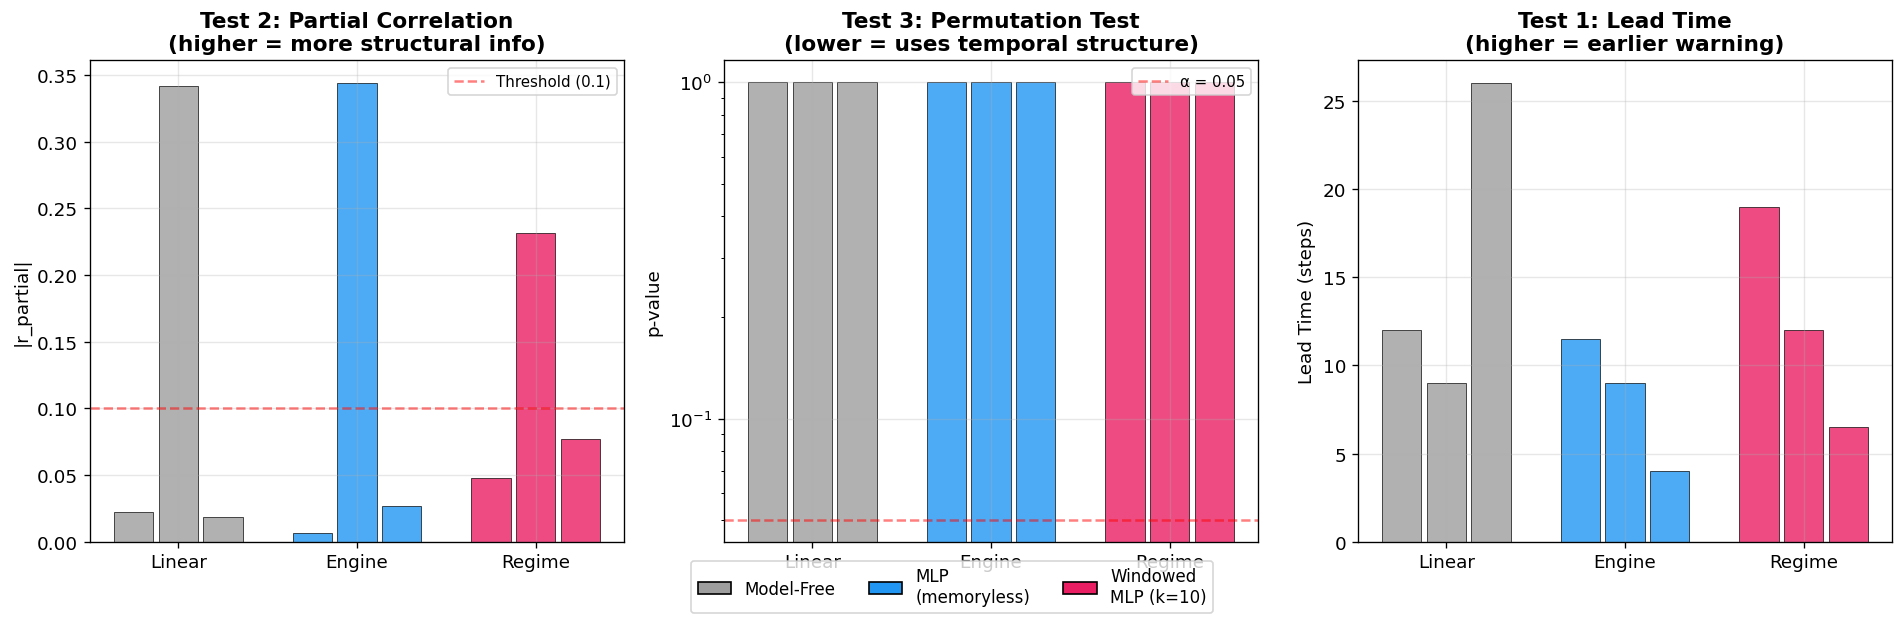

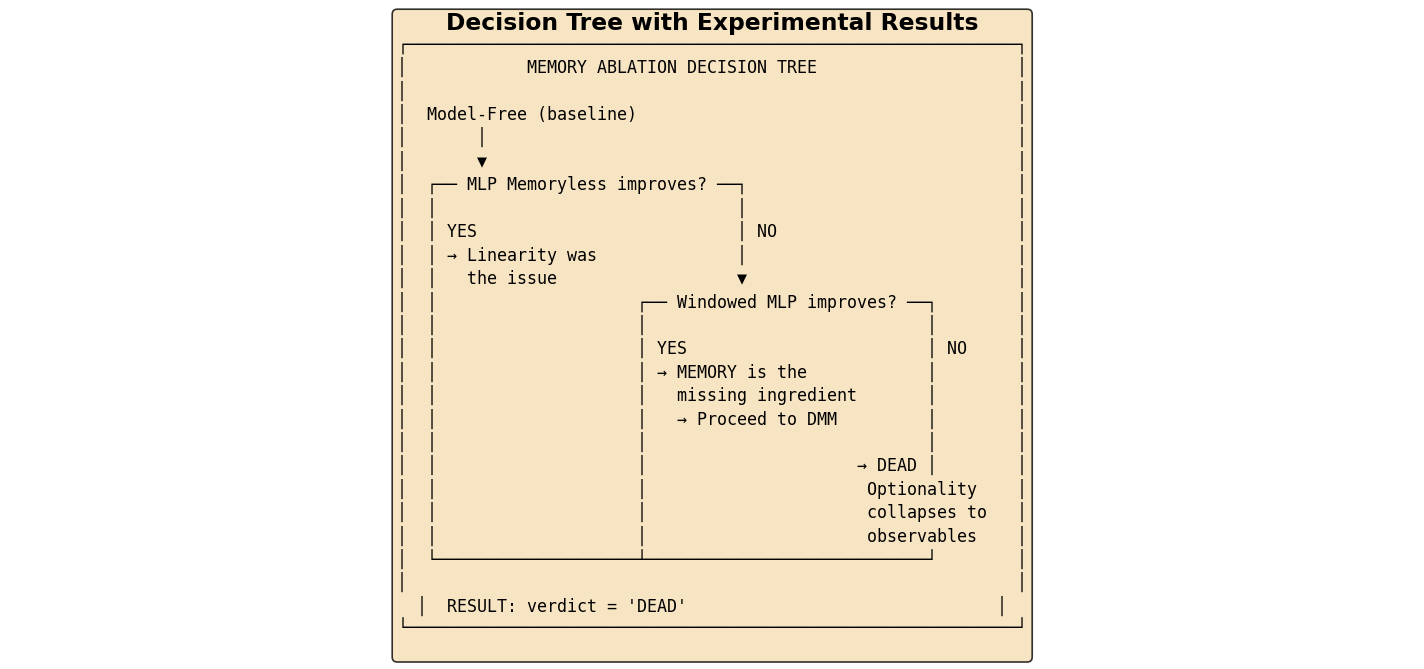


'Before building a powerful model,
 we must determine whether the signal exists at all.'


In [9]:
# ============================================================
# Visualization: Partial Correlation + Permutation across samplers
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
sys_names = list(SYSTEMS.keys())
sampler_labels = ["Model-Free", "MLP\n(memoryless)", "Windowed\nMLP (k=10)"]
colors = ["#9E9E9E", "#2196F3", "#E91E63"]

# ── Plot 1: Partial Correlation ──
ax = axes[0]
for i, sys_name in enumerate(sys_names):
    vals = [res[sys_name]["r_partial"] for res in ALL_RESULTS]
    x = np.arange(len(vals)) + i * 0.25 - 0.25
    ax.bar(
        x, vals, width=0.22, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5
    )
ax.axhline(
    y=PARTIAL_CORR_THRESHOLD,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"Threshold ({PARTIAL_CORR_THRESHOLD})",
)
ax.set_xticks(np.arange(len(sys_names)))
ax.set_xticklabels([s.capitalize() for s in sys_names])
ax.set_ylabel("|r_partial|")
ax.set_title(
    "Test 2: Partial Correlation\n(higher = more structural info)", fontweight="bold"
)
ax.legend(fontsize=9)

# ── Plot 2: Permutation p-value ──
ax = axes[1]
for i, sys_name in enumerate(sys_names):
    vals = [res[sys_name]["perm_p"] for res in ALL_RESULTS]
    x = np.arange(len(vals)) + i * 0.25 - 0.25
    ax.bar(
        x, vals, width=0.22, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5
    )
ax.axhline(
    y=PERM_P_THRESHOLD,
    color="red",
    linestyle="--",
    alpha=0.5,
    label=f"α = {PERM_P_THRESHOLD}",
)
ax.set_xticks(np.arange(len(sys_names)))
ax.set_xticklabels([s.capitalize() for s in sys_names])
ax.set_ylabel("p-value")
ax.set_title(
    "Test 3: Permutation Test\n(lower = uses temporal structure)", fontweight="bold"
)
ax.legend(fontsize=9)
ax.set_yscale("log")

# ── Plot 3: Lead Time ──
ax = axes[2]
for i, sys_name in enumerate(sys_names):
    vals = [res[sys_name]["lead_time_median"] for res in ALL_RESULTS]
    x = np.arange(len(vals)) + i * 0.25 - 0.25
    ax.bar(
        x, vals, width=0.22, color=colors, alpha=0.8, edgecolor="black", linewidth=0.5
    )
ax.set_xticks(np.arange(len(sys_names)))
ax.set_xticklabels([s.capitalize() for s in sys_names])
ax.set_ylabel("Lead Time (steps)")
ax.set_title("Test 1: Lead Time\n(higher = earlier warning)", fontweight="bold")

# Legend
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor=c, edgecolor="black", label=l)
    for c, l in zip(colors, sampler_labels)
]
fig.legend(
    handles=legend_elements,
    loc="lower center",
    ncol=3,
    fontsize=10,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()
plt.savefig(
    "../results/simulated/memory_ablation_comparison.png", dpi=150, bbox_inches="tight"
)
plt.show()

# ── Decision Tree Diagram ──
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
ax2.axis("off")

# Draw decision tree with results
tree_text = f"""
┌─────────────────────────────────────────────────────────────┐
│            MEMORY ABLATION DECISION TREE                    │
│                                                             │
│  Model-Free (baseline)                                      │
│       │                                                     │
│       ▼                                                     │
│  ┌── MLP Memoryless improves? ──┐                           │
│  │                              │                           │
│  │ YES                          │ NO                        │
│  │ → Linearity was              │                           │
│  │   the issue                  ▼                           │
│  │                    ┌── Windowed MLP improves? ──┐        │
│  │                    │                            │        │
│  │                    │ YES                        │ NO     │
│  │                    │ → MEMORY is the            │        │
│  │                    │   missing ingredient       │        │
│  │                    │   → Proceed to DMM         │        │
│  │                    │                            │        │
│  │                    │                     → DEAD │        │
│  │                    │                      Optionality    │
│  │                    │                      collapses to   │
│  │                    │                      observables    │
│  └────────────────────┴────────────────────────────┘        │
│                                                             │
│  RESULT: verdict = '{verdict}'                               │
└─────────────────────────────────────────────────────────────┘
"""
ax2.text(
    0.5,
    0.5,
    tree_text,
    transform=ax2.transAxes,
    fontsize=10,
    fontfamily="monospace",
    verticalalignment="center",
    horizontalalignment="center",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
)
ax2.set_title("Decision Tree with Experimental Results", fontweight="bold", fontsize=14)
plt.tight_layout()
plt.savefig(
    "../results/simulated/memory_ablation_decision_tree.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()

print("\n" + "=" * 70)
print("'Before building a powerful model,")
print(" we must determine whether the signal exists at all.'")
print("=" * 70)